In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import stats
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, plot_gradient, dlla_hw

sns.set_style('whitegrid')

In [13]:
x_prof, y_prof, x_att, y_att = fetch_traces(AscadRandomKey().default)

### Model creation

With model hyperparameters to be optimized.

In [14]:
model_parameters = {
    'activation': ['relu'],
    'optimizer': [Adam(lr=0.001)],
    'losses': ['categorical_crossentropy'],
    'batch_size': list(np.linspace(100, 300, 5).astype(int)),
    'epochs': list(np.linspace(5, 20, 4).astype(int))
}

def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [15]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [16]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [17]:
best_model.predict(x_att[:1])[0]

array([0.00200991, 0.02214885, 0.08528868, 0.19381912, 0.27099025,
       0.24000216, 0.1329307 , 0.04493532, 0.00787499], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [18]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

4.233286675065756

In [19]:
dlla_hw(best_model, x_att, y_att)

(0.0, 0.3107986800482999)

### Plot prediction distribution for all traces.

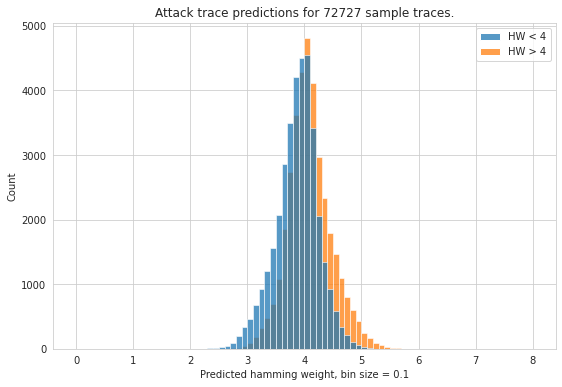

In [28]:
plot_predictions(best_model, x_att, y_att)

### Plot p-gradient.

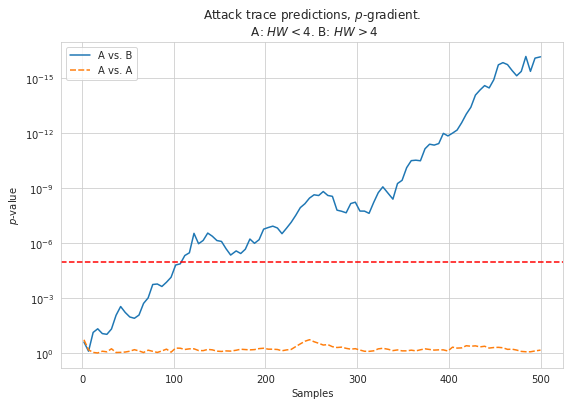

In [31]:
plot_gradient(best_model, x_att, y_att)